# Notebook for training tensorflow object detector API

## Downloads SSDLite Mobiledet model

In [6]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz -P pretrained_models/
!tar xf pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz --directory pretrained_models/
!mv /home/mikkel/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config /home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config

--2020-11-15 15:35:43--  http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.21.144, 2a00:1450:400f:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.21.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156413934 (149M) [application/x-tar]
Saving to: ‘pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz.1’

ssdlite_mobiledet_e 100%[===================>] 149.17M  61.4MB/s    in 2.4s    

2020-11-15 15:35:46 (61.4 MB/s) - ‘pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz.1’ saved [156413934/156413934]



## Dataset

In [7]:
dataset_path = '/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/'

## Edit pipeline config to configure the training

In [8]:
import tensorflow as tf
print("Tensorflow version", tf.__version__)
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tensorflow version 1.15.0
Sun Nov 15 15:35:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:09:00.0 Off |                  N/A |
| 28%   52C    P0    56W / 151W |    402MiB /  8119MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [9]:
pipeline = pipeline_pb2.TrainEvalPipelineConfig()
config_path = '/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config'#'/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03/ssd_mobilenet_v2_quantized_300x300_coco.config'#
# Read config file and converts it to editable pipeline
with tf.gfile.GFile(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline)
    

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = [dataset_path + 'train/Hole.tfrecord']
pipeline.train_input_reader.label_map_path = dataset_path + 'train/Hole_label_map.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = [dataset_path + 'valid/Hole.tfrecord']
pipeline.eval_input_reader[0].label_map_path = dataset_path + 'valid/Hole_label_map.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt'
pipeline.train_config.batch_size = 16
pipeline.train_config.num_steps = 50000
pipeline.model.ssd.num_classes = 1
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Traning IMPORTANT!!!!
pipeline.graph_rewriter.quantization.delay = 0
pipeline.graph_rewriter.quantization.weight_bits = 8
pipeline.graph_rewriter.quantization.activation_bits = 8

config_text = text_format.MessageToString(pipeline) # Back to text to write
with tf.gfile.Open(config_path, "wb") as f:
    f.write(config_text)

# This is out config after modifying
!cat '/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config'

model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobiledet_edgetpu"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97
          center: true
          scale: true
          epsilon: 0.001
          train: true
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: false
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        un

## Training

In [10]:
!python model_main.py \
        --logtostderr=true \
        --model_dir='/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320' \
        --pipeline_config_path='/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config'

W1115 15:36:02.897710 140333917796160 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I1115 15:36:02.897909 140333917796160 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1115 15:36:02.897978 140333917796160 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I1115 15:36:02.898042 140333917796160 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1115 15:36:02.898109 140333917796160 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1115 15:36:02.898196 140333917796160 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1115 15:36:14.066074 140333917796160 deprecation.py:323] From /home/mikkel/anaconda3/envs/tf1/lib/python3.6/site-packages/object_detection/inputs.py:109: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1115 15:36:14.235141 140333917796160 deprecation.py:323] From /home/mikkel/anaconda3/envs/tf1/lib/python3.6/site-packages/object_detection/inputs.py:93: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 inst

INFO:tensorflow:Running local_init_op.
I1115 15:37:02.487138 140333917796160 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1115 15:37:03.171928 140333917796160 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320/model.ckpt.
I1115 15:37:16.648977 140333917796160 basic_session_run_hooks.py:606] Saving checkpoints for 0 into /home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320/model.ckpt.
2020-11-15 15:37:39.485039: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-15 15:37:40.612078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
INFO:tensorflow:loss = 22.10158, ste

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W1115 15:47:27.028576 140333917796160 deprecation.py:323] From /home/mikkel/anaconda3/envs/tf1/lib/python3.6/site-packages/object_detection/utils/visualization_utils.py:618: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecate

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1144: /home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320/model.ckpt-1144
I1115 15:47:41.865291 140333917796160 estimator.py:2109] Saving 'checkpoint_path' summary for global step 1144: /home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320/model.ckpt-1144
INFO:tensorflow:global_step/sec: 1.41852
I1115 15:48:09.391179 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 1.41852
INFO:tensorflow:loss = 2.4336376, step = 1200 (70.496 sec)
I1115 15:48:09.393506 140333917796160 basic_session_run_hooks.py:260] loss = 2.4336376, step = 1200 (70.496 sec)
INFO:tensorflow:global_step/sec: 2.05022
I1115 15:48:58.166350 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05022
INFO:tensorflow:loss = 2.3137078, step = 1300 (48.775 sec)
I1115 15:48:58.168504 140333917796

INFO:tensorflow:Done calling model_fn.
I1115 15:57:27.847045 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T15:57:27Z
I1115 15:57:27.860815 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T15:57:27Z
INFO:tensorflow:Graph was finalized.
I1115 15:57:28.666409 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 15:57:28.666865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 15:57:28.667252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 15:57:28.667309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 15:57:28.66

INFO:tensorflow:global_step/sec: 2.05097
I1115 15:59:04.038028 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05097
INFO:tensorflow:loss = 0.9320574, step = 2500 (48.757 sec)
I1115 15:59:04.040161 140333917796160 basic_session_run_hooks.py:260] loss = 0.9320574, step = 2500 (48.757 sec)
INFO:tensorflow:global_step/sec: 2.05909
I1115 15:59:52.603243 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05909
INFO:tensorflow:loss = 2.9366698, step = 2600 (48.566 sec)
I1115 15:59:52.606185 140333917796160 basic_session_run_hooks.py:260] loss = 2.9366698, step = 2600 (48.566 sec)
INFO:tensorflow:global_step/sec: 2.0519
I1115 16:00:41.338606 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.0519
INFO:tensorflow:loss = 2.084843, step = 2700 (48.734 sec)
I1115 16:00:41.340644 140333917796160 basic_session_run_hooks.py:260] loss = 2.084843, step = 2700 (48.734 sec)
INFO:tensorflow:global_step/sec: 2.04886
I1115 16:01:30.146279 140333917796160 b

INFO:tensorflow:Calling model_fn.
I1115 16:17:22.494928 140333917796160 estimator.py:1148] Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 16:17:24.654150 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 16:17:24.722889 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 16:17:24.789224 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 16:17:24.856381 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 16:17:24.926559 140333917796160 convolutional_box_predictor.py:156] 

INFO:tensorflow:Done calling model_fn.
I1115 16:17:27.819344 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T16:17:27Z
I1115 16:17:27.832922 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T16:17:27Z
INFO:tensorflow:Graph was finalized.
I1115 16:17:28.617475 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 16:17:28.617925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 16:17:28.618313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 16:17:28.618372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 16:17:28.61

INFO:tensorflow:global_step/sec: 2.05605
I1115 16:18:54.901096 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05605
INFO:tensorflow:loss = 1.5776, step = 4900 (48.637 sec)
I1115 16:18:54.903721 140333917796160 basic_session_run_hooks.py:260] loss = 1.5776, step = 4900 (48.637 sec)
INFO:tensorflow:global_step/sec: 2.05166
I1115 16:19:43.642001 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05166
INFO:tensorflow:loss = 2.5376625, step = 5000 (48.740 sec)
I1115 16:19:43.644065 140333917796160 basic_session_run_hooks.py:260] loss = 2.5376625, step = 5000 (48.740 sec)
INFO:tensorflow:global_step/sec: 2.05097
I1115 16:20:32.399353 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05097
INFO:tensorflow:loss = 1.774604, step = 5100 (48.758 sec)
I1115 16:20:32.401679 140333917796160 basic_session_run_hooks.py:260] loss = 1.774604, step = 5100 (48.758 sec)
INFO:tensorflow:global_step/sec: 2.05805
I1115 16:21:20.988985 140333917796160 basic

INFO:tensorflow:Done calling model_fn.
I1115 16:27:28.309053 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T16:27:28Z
I1115 16:27:28.322845 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T16:27:28Z
INFO:tensorflow:Graph was finalized.
I1115 16:27:29.111794 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 16:27:29.112247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 16:27:29.112632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 16:27:29.112692: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 16:27:29.11

INFO:tensorflow:global_step/sec: 2.05566
I1115 16:28:59.642408 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05566
INFO:tensorflow:loss = 1.8461664, step = 6100 (48.645 sec)
I1115 16:28:59.643954 140333917796160 basic_session_run_hooks.py:260] loss = 1.8461664, step = 6100 (48.645 sec)
INFO:tensorflow:global_step/sec: 2.06537
I1115 16:29:48.060101 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06537
INFO:tensorflow:loss = 1.099789, step = 6200 (48.418 sec)
I1115 16:29:48.062435 140333917796160 basic_session_run_hooks.py:260] loss = 1.099789, step = 6200 (48.418 sec)
INFO:tensorflow:global_step/sec: 2.05655
I1115 16:30:36.685263 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05655
INFO:tensorflow:loss = 0.95576143, step = 6300 (48.625 sec)
I1115 16:30:36.687394 140333917796160 basic_session_run_hooks.py:260] loss = 0.95576143, step = 6300 (48.625 sec)
INFO:tensorflow:global_step/sec: 2.05403
I1115 16:31:25.369929 1403339177961

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
I1115 16:37:27.389353 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
I1115 16:37:27.389503 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_3_1x1_128/add_fold
I1115 16:37:27.389648 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_3_1x1_128/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_3_3x3_s2_256_depthwise/add_fold
I1115 16:37:27.389800 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_3_

INFO:tensorflow:Running local_init_op.
I1115 16:37:31.447125 140333917796160 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1115 16:37:31.653759 140333917796160 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 87 images.
I1115 16:37:40.060581 140328157820672 coco_evaluation.py:293] Performing evaluation on 87 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I1115 16:37:40.062458 140328157820672 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I1115 16:37:40.069598 140328157820672 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.84s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=  

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 16:47:22.654005 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 16:47:22.654582 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 16:47:22.654710 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 16:47:22.654794 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 16:47:28.355876 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T16:47:28Z
I1115 16:47:28.369533 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T16:47:28Z
INFO:tensorflow:Graph was finalized.
I1115 16:47:29.164813 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 16:47:29.165306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 16:47:29.165714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 16:47:29.165782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 16:47:29.16

INFO:tensorflow:global_step/sec: 2.05874
I1115 16:49:09.601962 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05874
INFO:tensorflow:loss = 0.95776534, step = 8500 (48.573 sec)
I1115 16:49:09.603957 140333917796160 basic_session_run_hooks.py:260] loss = 0.95776534, step = 8500 (48.573 sec)
INFO:tensorflow:global_step/sec: 2.05372
I1115 16:49:58.294250 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05372
INFO:tensorflow:loss = 0.63945776, step = 8600 (48.693 sec)
I1115 16:49:58.296989 140333917796160 basic_session_run_hooks.py:260] loss = 0.63945776, step = 8600 (48.693 sec)
INFO:tensorflow:global_step/sec: 2.05328
I1115 16:50:46.996876 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05328
INFO:tensorflow:loss = 0.9834908, step = 8700 (48.702 sec)
I1115 16:50:46.999398 140333917796160 basic_session_run_hooks.py:260] loss = 0.9834908, step = 8700 (48.702 sec)
INFO:tensorflow:global_step/sec: 2.05422
I1115 16:51:35.677263 140333917

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_8/Conv/add_fold
I1115 16:57:27.421301 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_8/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_9/Conv/add_fold
I1115 16:57:27.421545 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_9/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_2/Conv/add_fold
I1115 16:57:27.421791 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_2/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_2/SeparableConv2d/add_fold
I1115 16:57:27.421956 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_2/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU

INFO:tensorflow:Done calling model_fn.
I1115 16:57:28.322330 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T16:57:28Z
I1115 16:57:28.336686 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T16:57:28Z
INFO:tensorflow:Graph was finalized.
I1115 16:57:29.131212 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 16:57:29.131703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 16:57:29.132134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 16:57:29.132201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 16:57:29.13

INFO:tensorflow:global_step/sec: 2.04778
I1115 16:59:14.735504 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04778
INFO:tensorflow:loss = 0.44157487, step = 9700 (48.833 sec)
I1115 16:59:14.737716 140333917796160 basic_session_run_hooks.py:260] loss = 0.44157487, step = 9700 (48.833 sec)
INFO:tensorflow:global_step/sec: 2.04885
I1115 17:00:03.543412 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04885
INFO:tensorflow:loss = 0.6484193, step = 9800 (48.808 sec)
I1115 17:00:03.545831 140333917796160 basic_session_run_hooks.py:260] loss = 0.6484193, step = 9800 (48.808 sec)
INFO:tensorflow:global_step/sec: 2.05007
I1115 17:00:52.322342 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05007
INFO:tensorflow:loss = 0.8096114, step = 9900 (48.779 sec)
I1115 17:00:52.324508 140333917796160 basic_session_run_hooks.py:260] loss = 0.8096114, step = 9900 (48.779 sec)
INFO:tensorflow:global_step/sec: 2.05277
I1115 17:01:41.037047 14033391779

INFO:tensorflow:Done calling model_fn.
I1115 17:07:29.194679 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T17:07:29Z
I1115 17:07:29.208274 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T17:07:29Z
INFO:tensorflow:Graph was finalized.
I1115 17:07:30.000271 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 17:07:30.000736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 17:07:30.001122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 17:07:30.001178: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 17:07:30.00

INFO:tensorflow:global_step/sec: 2.05442
I1115 17:08:30.871154 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05442
INFO:tensorflow:loss = 1.3441229, step = 10800 (48.676 sec)
I1115 17:08:30.873821 140333917796160 basic_session_run_hooks.py:260] loss = 1.3441229, step = 10800 (48.676 sec)
INFO:tensorflow:global_step/sec: 2.05173
I1115 17:09:19.610422 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05173
INFO:tensorflow:loss = 1.3794787, step = 10900 (48.739 sec)
I1115 17:09:19.612540 140333917796160 basic_session_run_hooks.py:260] loss = 1.3794787, step = 10900 (48.739 sec)
INFO:tensorflow:global_step/sec: 2.05027
I1115 17:10:08.384600 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05027
INFO:tensorflow:loss = 1.687917, step = 11000 (48.774 sec)
I1115 17:10:08.387026 140333917796160 basic_session_run_hooks.py:260] loss = 1.687917, step = 11000 (48.774 sec)
INFO:tensorflow:global_step/sec: 2.06287
I1115 17:10:56.860745 140333917

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 17:27:23.401594 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 17:27:23.402162 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 17:27:23.402258 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 17:27:23.402333 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 17:27:29.403249 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T17:27:29Z
I1115 17:27:29.417053 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T17:27:29Z
INFO:tensorflow:Graph was finalized.
I1115 17:27:30.206686 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 17:27:30.207159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 17:27:30.207547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 17:27:30.207603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 17:27:30.20

INFO:tensorflow:global_step/sec: 2.04746
I1115 17:29:10.341068 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04746
INFO:tensorflow:loss = 0.9763837, step = 13300 (48.841 sec)
I1115 17:29:10.343321 140333917796160 basic_session_run_hooks.py:260] loss = 0.9763837, step = 13300 (48.841 sec)
INFO:tensorflow:global_step/sec: 2.06803
I1115 17:29:58.696336 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06803
INFO:tensorflow:loss = 1.1180277, step = 13400 (48.355 sec)
I1115 17:29:58.698706 140333917796160 basic_session_run_hooks.py:260] loss = 1.1180277, step = 13400 (48.355 sec)
INFO:tensorflow:global_step/sec: 2.04913
I1115 17:30:47.497516 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04913
INFO:tensorflow:loss = 0.8730652, step = 13500 (48.801 sec)
I1115 17:30:47.500047 140333917796160 basic_session_run_hooks.py:260] loss = 0.8730652, step = 13500 (48.801 sec)
INFO:tensorflow:global_step/sec: 2.05038
I1115 17:31:36.268898 1403339

INFO:tensorflow:Done calling model_fn.
I1115 17:37:29.475604 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T17:37:29Z
I1115 17:37:29.489202 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T17:37:29Z
INFO:tensorflow:Graph was finalized.
I1115 17:37:30.601157 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 17:37:30.601686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 17:37:30.602105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 17:37:30.602166: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 17:37:30.60

INFO:tensorflow:global_step/sec: 2.05366
I1115 17:39:14.740350 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05366
INFO:tensorflow:loss = 0.8334724, step = 14500 (48.693 sec)
I1115 17:39:14.742484 140333917796160 basic_session_run_hooks.py:260] loss = 0.8334724, step = 14500 (48.693 sec)
INFO:tensorflow:global_step/sec: 2.05107
I1115 17:40:03.495338 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05107
INFO:tensorflow:loss = 0.80295235, step = 14600 (48.755 sec)
I1115 17:40:03.497697 140333917796160 basic_session_run_hooks.py:260] loss = 0.80295235, step = 14600 (48.755 sec)
INFO:tensorflow:global_step/sec: 2.05162
I1115 17:40:52.237237 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05162
INFO:tensorflow:loss = 0.627362, step = 14700 (48.742 sec)
I1115 17:40:52.239457 140333917796160 basic_session_run_hooks.py:260] loss = 0.627362, step = 14700 (48.742 sec)
INFO:tensorflow:global_step/sec: 2.04544
I1115 17:41:41.126496 1403339

INFO:tensorflow:Done calling model_fn.
I1115 17:47:29.981726 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T17:47:29Z
I1115 17:47:29.995623 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T17:47:29Z
INFO:tensorflow:Graph was finalized.
I1115 17:47:30.793371 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 17:47:30.793846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 17:47:30.794246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 17:47:30.794304: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 17:47:30.79

INFO:tensorflow:global_step/sec: 2.06432
I1115 17:48:34.870546 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06432
INFO:tensorflow:loss = 0.8291193, step = 15600 (48.444 sec)
I1115 17:48:34.872773 140333917796160 basic_session_run_hooks.py:260] loss = 0.8291193, step = 15600 (48.444 sec)
INFO:tensorflow:global_step/sec: 2.04982
I1115 17:49:23.655306 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04982
INFO:tensorflow:loss = 0.6499443, step = 15700 (48.785 sec)
I1115 17:49:23.657524 140333917796160 basic_session_run_hooks.py:260] loss = 0.6499443, step = 15700 (48.785 sec)
INFO:tensorflow:global_step/sec: 2.05058
I1115 17:50:12.422044 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05058
INFO:tensorflow:loss = 0.95568275, step = 15800 (48.767 sec)
I1115 17:50:12.424633 140333917796160 basic_session_run_hooks.py:260] loss = 0.95568275, step = 15800 (48.767 sec)
INFO:tensorflow:global_step/sec: 2.05626
I1115 17:51:01.053948 14033

INFO:tensorflow:Skipping quant after BoxPredictor_1/BoxEncodingPredictor_depthwise/add_fold
I1115 17:57:29.582585 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_1/BoxEncodingPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_1/ClassPredictor_depthwise/add_fold
I1115 17:57:29.582740 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_1/ClassPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_2/BoxEncodingPredictor_depthwise/add_fold
I1115 17:57:29.582894 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_2/BoxEncodingPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_2/ClassPredictor_depthwise/add_fold
I1115 17:57:29.583047 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_2/ClassPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_3/BoxEncodingPredictor_depthwise/add_fold
I1115 17:57:29.583200 140333917796160 qu

INFO:tensorflow:global_step/sec: 1.45272
I1115 17:57:51.059205 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 1.45272
INFO:tensorflow:loss = 0.6640048, step = 16700 (68.836 sec)
I1115 17:57:51.061391 140333917796160 basic_session_run_hooks.py:260] loss = 0.6640048, step = 16700 (68.836 sec)
INFO:tensorflow:global_step/sec: 2.05755
I1115 17:58:39.660798 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05755
INFO:tensorflow:loss = 0.8363131, step = 16800 (48.602 sec)
I1115 17:58:39.663500 140333917796160 basic_session_run_hooks.py:260] loss = 0.8363131, step = 16800 (48.602 sec)
INFO:tensorflow:global_step/sec: 2.05002
I1115 17:59:28.440857 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05002
INFO:tensorflow:loss = 0.66420996, step = 16900 (48.780 sec)
I1115 17:59:28.443093 140333917796160 basic_session_run_hooks.py:260] loss = 0.66420996, step = 16900 (48.780 sec)
INFO:tensorflow:global_step/sec: 2.06042
I1115 18:00:16.974719 14033

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
I1115 18:07:29.917520 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
I1115 18:07:29.917668 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_3_1x1_128/add_fold
I1115 18:07:29.917816 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_3_1x1_128/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_3_3x3_s2_256_depthwise/add_fold
I1115 18:07:29.917973 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_3_

INFO:tensorflow:Running local_init_op.
I1115 18:07:33.639227 140333917796160 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1115 18:07:33.838573 140333917796160 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 87 images.
I1115 18:07:42.522689 140328182998784 coco_evaluation.py:293] Performing evaluation on 87 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I1115 18:07:42.524034 140328182998784 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I1115 18:07:42.531889 140328182998784 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50      | area=  

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 18:17:24.862281 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 18:17:24.862891 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 18:17:24.863010 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 18:17:24.863092 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 18:17:30.850878 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T18:17:30Z
I1115 18:17:30.864916 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T18:17:30Z
INFO:tensorflow:Graph was finalized.
I1115 18:17:31.662344 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 18:17:31.662819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 18:17:31.663202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 18:17:31.663258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 18:17:31.66

INFO:tensorflow:global_step/sec: 2.05177
I1115 18:18:49.218619 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05177
INFO:tensorflow:loss = 0.6161556, step = 19200 (48.739 sec)
I1115 18:18:49.220809 140333917796160 basic_session_run_hooks.py:260] loss = 0.6161556, step = 19200 (48.739 sec)
INFO:tensorflow:global_step/sec: 2.0561
I1115 18:19:37.854438 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.0561
INFO:tensorflow:loss = 0.46349865, step = 19300 (48.636 sec)
I1115 18:19:37.856767 140333917796160 basic_session_run_hooks.py:260] loss = 0.46349865, step = 19300 (48.636 sec)
INFO:tensorflow:global_step/sec: 2.05816
I1115 18:20:26.441472 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05816
INFO:tensorflow:loss = 0.43677035, step = 19400 (48.587 sec)
I1115 18:20:26.443716 140333917796160 basic_session_run_hooks.py:260] loss = 0.43677035, step = 19400 (48.587 sec)
INFO:tensorflow:global_step/sec: 2.04595
I1115 18:21:15.318474 14033

INFO:tensorflow:Done calling model_fn.
I1115 18:27:30.999293 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T18:27:31Z
I1115 18:27:31.013033 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T18:27:31Z
INFO:tensorflow:Graph was finalized.
I1115 18:27:31.812770 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 18:27:31.813252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 18:27:31.813638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 18:27:31.813695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 18:27:31.81

INFO:tensorflow:global_step/sec: 2.05778
I1115 18:28:53.939149 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05778
INFO:tensorflow:loss = 0.7407444, step = 20400 (48.596 sec)
I1115 18:28:53.941137 140333917796160 basic_session_run_hooks.py:260] loss = 0.7407444, step = 20400 (48.596 sec)
INFO:tensorflow:global_step/sec: 2.07147
I1115 18:29:42.214002 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.07147
INFO:tensorflow:loss = 0.6062496, step = 20500 (48.274 sec)
I1115 18:29:42.215347 140333917796160 basic_session_run_hooks.py:260] loss = 0.6062496, step = 20500 (48.274 sec)
INFO:tensorflow:global_step/sec: 2.05683
I1115 18:30:30.832542 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05683
INFO:tensorflow:loss = 0.4628275, step = 20600 (48.619 sec)
I1115 18:30:30.834762 140333917796160 basic_session_run_hooks.py:260] loss = 0.4628275, step = 20600 (48.619 sec)
INFO:tensorflow:global_step/sec: 2.05685
I1115 18:31:19.450608 1403339

INFO:tensorflow:Done calling model_fn.
I1115 18:37:31.002040 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T18:37:31Z
I1115 18:37:31.015851 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T18:37:31Z
INFO:tensorflow:Graph was finalized.
I1115 18:37:31.807386 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 18:37:31.807897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 18:37:31.808322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 18:37:31.808391: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 18:37:31.80

INFO:tensorflow:global_step/sec: 2.04707
I1115 18:38:57.376639 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04707
INFO:tensorflow:loss = 0.6388038, step = 21600 (48.851 sec)
I1115 18:38:57.378952 140333917796160 basic_session_run_hooks.py:260] loss = 0.6388038, step = 21600 (48.851 sec)
INFO:tensorflow:global_step/sec: 2.05438
I1115 18:39:46.053037 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05438
INFO:tensorflow:loss = 0.46852857, step = 21700 (48.677 sec)
I1115 18:39:46.055904 140333917796160 basic_session_run_hooks.py:260] loss = 0.46852857, step = 21700 (48.677 sec)
INFO:tensorflow:global_step/sec: 2.05275
I1115 18:40:34.768225 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05275
INFO:tensorflow:loss = 0.42000067, step = 21800 (48.715 sec)
I1115 18:40:34.770917 140333917796160 basic_session_run_hooks.py:260] loss = 0.42000067, step = 21800 (48.715 sec)
INFO:tensorflow:global_step/sec: 2.06042
I1115 18:41:23.301936 140

INFO:tensorflow:Done calling model_fn.
I1115 18:47:31.587525 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T18:47:31Z
I1115 18:47:31.601215 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T18:47:31Z
INFO:tensorflow:Graph was finalized.
I1115 18:47:32.386623 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 18:47:32.387107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 18:47:32.387491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 18:47:32.387549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 18:47:32.38

INFO:tensorflow:global_step/sec: 2.05734
I1115 18:49:01.918457 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05734
INFO:tensorflow:loss = 0.41265574, step = 22800 (48.606 sec)
I1115 18:49:01.920343 140333917796160 basic_session_run_hooks.py:260] loss = 0.41265574, step = 22800 (48.606 sec)
INFO:tensorflow:global_step/sec: 2.06211
I1115 18:49:50.412601 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06211
INFO:tensorflow:loss = 0.2979027, step = 22900 (48.494 sec)
I1115 18:49:50.414843 140333917796160 basic_session_run_hooks.py:260] loss = 0.2979027, step = 22900 (48.494 sec)
INFO:tensorflow:global_step/sec: 2.05059
I1115 18:50:39.179060 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05059
INFO:tensorflow:loss = 0.5952637, step = 23000 (48.767 sec)
I1115 18:50:39.181345 140333917796160 basic_session_run_hooks.py:260] loss = 0.5952637, step = 23000 (48.767 sec)
INFO:tensorflow:global_step/sec: 2.05225
I1115 18:51:27.906135 14033

INFO:tensorflow:Skipping quant after BoxPredictor_4/ClassPredictor_depthwise/add_fold
I1115 18:57:30.787201 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_4/ClassPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_5/BoxEncodingPredictor_depthwise/add_fold
I1115 18:57:30.787381 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_5/BoxEncodingPredictor_depthwise/add_fold
INFO:tensorflow:Skipping quant after BoxPredictor_5/ClassPredictor_depthwise/add_fold
I1115 18:57:30.787562 140333917796160 quantize.py:299] Skipping quant after BoxPredictor_5/ClassPredictor_depthwise/add_fold
INFO:tensorflow:Done calling model_fn.
I1115 18:57:31.692780 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T18:57:31Z
I1115 18:57:31.709924 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T18:57:31Z
INFO:tensorflow:Graph was finalized.
I1115 18:57:32.501830 140333917796160 

INFO:tensorflow:global_step/sec: 1.4414
I1115 18:58:18.243471 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 1.4414
INFO:tensorflow:loss = 0.38250318, step = 23900 (69.377 sec)
I1115 18:58:18.245732 140333917796160 basic_session_run_hooks.py:260] loss = 0.38250318, step = 23900 (69.377 sec)
INFO:tensorflow:global_step/sec: 2.06133
I1115 18:59:06.755685 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06133
INFO:tensorflow:loss = 0.35572293, step = 24000 (48.512 sec)
I1115 18:59:06.757946 140333917796160 basic_session_run_hooks.py:260] loss = 0.35572293, step = 24000 (48.512 sec)
INFO:tensorflow:global_step/sec: 2.04599
I1115 18:59:55.631682 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04599
INFO:tensorflow:loss = 0.4710964, step = 24100 (48.876 sec)
I1115 18:59:55.634239 140333917796160 basic_session_run_hooks.py:260] loss = 0.4710964, step = 24100 (48.876 sec)
INFO:tensorflow:global_step/sec: 2.04284
I1115 19:00:44.583037 14033

INFO:tensorflow:Done calling model_fn.
I1115 19:07:31.488158 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T19:07:31Z
I1115 19:07:31.503432 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T19:07:31Z
INFO:tensorflow:Graph was finalized.
I1115 19:07:32.299066 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 19:07:32.299564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 19:07:32.299951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 19:07:32.300010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 19:07:32.30

INFO:tensorflow:global_step/sec: 2.05478
I1115 19:09:12.298059 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05478
INFO:tensorflow:loss = 0.53603244, step = 25200 (48.667 sec)
I1115 19:09:12.299876 140333917796160 basic_session_run_hooks.py:260] loss = 0.53603244, step = 25200 (48.667 sec)
INFO:tensorflow:global_step/sec: 2.06139
I1115 19:10:00.809215 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06139
INFO:tensorflow:loss = 1.1202327, step = 25300 (48.511 sec)
I1115 19:10:00.811339 140333917796160 basic_session_run_hooks.py:260] loss = 1.1202327, step = 25300 (48.511 sec)
INFO:tensorflow:global_step/sec: 2.05491
I1115 19:10:49.473069 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05491
INFO:tensorflow:loss = 1.0289593, step = 25400 (48.664 sec)
I1115 19:10:49.475331 140333917796160 basic_session_run_hooks.py:260] loss = 1.0289593, step = 25400 (48.664 sec)
INFO:tensorflow:global_step/sec: 2.05379
I1115 19:11:38.163699 14033

INFO:tensorflow:Done calling model_fn.
I1115 19:17:31.597558 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T19:17:31Z
I1115 19:17:31.611267 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T19:17:31Z
INFO:tensorflow:Graph was finalized.
I1115 19:17:32.406528 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 19:17:32.407037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 19:17:32.407469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 19:17:32.407538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 19:17:32.40

INFO:tensorflow:global_step/sec: 2.05815
I1115 19:19:16.582920 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05815
INFO:tensorflow:loss = 0.5741888, step = 26400 (48.587 sec)
I1115 19:19:16.585214 140333917796160 basic_session_run_hooks.py:260] loss = 0.5741888, step = 26400 (48.587 sec)
INFO:tensorflow:global_step/sec: 2.05319
I1115 19:20:05.287553 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05319
INFO:tensorflow:loss = 0.67812574, step = 26500 (48.705 sec)
I1115 19:20:05.289814 140333917796160 basic_session_run_hooks.py:260] loss = 0.67812574, step = 26500 (48.705 sec)
INFO:tensorflow:global_step/sec: 2.05894
I1115 19:20:53.856172 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05894
INFO:tensorflow:loss = 0.4482613, step = 26600 (48.569 sec)
I1115 19:20:53.858425 140333917796160 basic_session_run_hooks.py:260] loss = 0.4482613, step = 26600 (48.569 sec)
INFO:tensorflow:global_step/sec: 2.04865
I1115 19:21:42.668718 14033

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 19:37:26.099962 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 19:37:26.100544 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 19:37:26.100669 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 19:37:26.100761 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 19:37:32.235331 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T19:37:32Z
I1115 19:37:32.249133 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T19:37:32Z
INFO:tensorflow:Graph was finalized.
I1115 19:37:33.042735 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 19:37:33.043243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 19:37:33.043631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 19:37:33.043691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 19:37:33.04

INFO:tensorflow:global_step/sec: 2.04088
I1115 19:39:07.468636 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04088
INFO:tensorflow:loss = 0.69818515, step = 28800 (48.999 sec)
I1115 19:39:07.471113 140333917796160 basic_session_run_hooks.py:260] loss = 0.69818515, step = 28800 (48.999 sec)
INFO:tensorflow:global_step/sec: 2.05741
I1115 19:39:56.073488 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05741
INFO:tensorflow:loss = 0.69689333, step = 28900 (48.605 sec)
I1115 19:39:56.075856 140333917796160 basic_session_run_hooks.py:260] loss = 0.69689333, step = 28900 (48.605 sec)
INFO:tensorflow:global_step/sec: 2.04386
I1115 19:40:45.000681 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04386
INFO:tensorflow:loss = 0.6697609, step = 29000 (48.928 sec)
I1115 19:40:45.003441 140333917796160 basic_session_run_hooks.py:260] loss = 0.6697609, step = 29000 (48.928 sec)
INFO:tensorflow:global_step/sec: 2.04585
I1115 19:41:33.879952 140

INFO:tensorflow:Done calling model_fn.
I1115 19:47:32.312857 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T19:47:32Z
I1115 19:47:32.326512 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T19:47:32Z
INFO:tensorflow:Graph was finalized.
I1115 19:47:33.116186 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 19:47:33.116694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 19:47:33.117081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 19:47:33.117142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 19:47:33.11

INFO:tensorflow:global_step/sec: 2.0658
I1115 19:49:12.059551 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.0658
INFO:tensorflow:loss = 0.95544213, step = 30000 (48.407 sec)
I1115 19:49:12.061118 140333917796160 basic_session_run_hooks.py:260] loss = 0.95544213, step = 30000 (48.407 sec)
INFO:tensorflow:global_step/sec: 2.06381
I1115 19:50:00.513886 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06381
INFO:tensorflow:loss = 0.9449086, step = 30100 (48.455 sec)
I1115 19:50:00.516307 140333917796160 basic_session_run_hooks.py:260] loss = 0.9449086, step = 30100 (48.455 sec)
INFO:tensorflow:global_step/sec: 2.05358
I1115 19:50:49.209172 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05358
INFO:tensorflow:loss = 0.6454632, step = 30200 (48.695 sec)
I1115 19:50:49.211204 140333917796160 basic_session_run_hooks.py:260] loss = 0.6454632, step = 30200 (48.695 sec)
INFO:tensorflow:global_step/sec: 2.06159
I1115 19:51:37.715394 1403339

INFO:tensorflow:Done calling model_fn.
I1115 19:57:33.669381 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T19:57:33Z
I1115 19:57:33.684751 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T19:57:33Z
INFO:tensorflow:Graph was finalized.
I1115 19:57:34.845572 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 19:57:34.846068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 19:57:34.846455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 19:57:34.846514: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 19:57:34.84

INFO:tensorflow:global_step/sec: 2.05189
I1115 19:59:19.199716 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05189
INFO:tensorflow:loss = 0.6672646, step = 31200 (48.735 sec)
I1115 19:59:19.201840 140333917796160 basic_session_run_hooks.py:260] loss = 0.6672646, step = 31200 (48.735 sec)
INFO:tensorflow:global_step/sec: 2.06881
I1115 20:00:07.536618 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06881
INFO:tensorflow:loss = 0.7798808, step = 31300 (48.337 sec)
I1115 20:00:07.539022 140333917796160 basic_session_run_hooks.py:260] loss = 0.7798808, step = 31300 (48.337 sec)
INFO:tensorflow:global_step/sec: 2.04869
I1115 20:00:56.348232 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04869
INFO:tensorflow:loss = 0.57906544, step = 31400 (48.812 sec)
I1115 20:00:56.350831 140333917796160 basic_session_run_hooks.py:260] loss = 0.57906544, step = 31400 (48.812 sec)
INFO:tensorflow:global_step/sec: 2.05098
I1115 20:01:45.105500 14033

INFO:tensorflow:Done calling model_fn.
I1115 20:07:32.374919 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T20:07:32Z
I1115 20:07:32.388660 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T20:07:32Z
INFO:tensorflow:Graph was finalized.
I1115 20:07:33.187910 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 20:07:33.188390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 20:07:33.188788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 20:07:33.188846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 20:07:33.18

INFO:tensorflow:global_step/sec: 2.05193
I1115 20:08:34.687325 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05193
INFO:tensorflow:loss = 0.5685124, step = 32300 (48.735 sec)
I1115 20:08:34.689990 140333917796160 basic_session_run_hooks.py:260] loss = 0.5685124, step = 32300 (48.735 sec)
INFO:tensorflow:global_step/sec: 2.04877
I1115 20:09:23.497006 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04877
INFO:tensorflow:loss = 0.57214606, step = 32400 (48.809 sec)
I1115 20:09:23.499133 140333917796160 basic_session_run_hooks.py:260] loss = 0.57214606, step = 32400 (48.809 sec)
INFO:tensorflow:global_step/sec: 2.05956
I1115 20:10:12.050993 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05956
INFO:tensorflow:loss = 0.76702726, step = 32500 (48.554 sec)
I1115 20:10:12.053178 140333917796160 basic_session_run_hooks.py:260] loss = 0.76702726, step = 32500 (48.554 sec)
INFO:tensorflow:global_step/sec: 2.06047
I1115 20:11:00.583683 140

INFO:tensorflow:Done calling model_fn.
I1115 20:17:32.892628 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T20:17:32Z
I1115 20:17:32.906763 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T20:17:32Z
INFO:tensorflow:Graph was finalized.
I1115 20:17:33.695690 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 20:17:33.696153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 20:17:33.696541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 20:17:33.696600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 20:17:33.69

INFO:tensorflow:global_step/sec: 2.04746
I1115 20:18:39.805207 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04746
INFO:tensorflow:loss = 0.45899844, step = 33500 (48.841 sec)
I1115 20:18:39.807158 140333917796160 basic_session_run_hooks.py:260] loss = 0.45899844, step = 33500 (48.841 sec)
INFO:tensorflow:global_step/sec: 2.03869
I1115 20:19:28.856490 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.03869
INFO:tensorflow:loss = 0.6736839, step = 33600 (49.052 sec)
I1115 20:19:28.859097 140333917796160 basic_session_run_hooks.py:260] loss = 0.6736839, step = 33600 (49.052 sec)
INFO:tensorflow:global_step/sec: 2.04668
I1115 20:20:17.715965 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04668
INFO:tensorflow:loss = 0.6238109, step = 33700 (48.859 sec)
I1115 20:20:17.717948 140333917796160 basic_session_run_hooks.py:260] loss = 0.6238109, step = 33700 (48.859 sec)
INFO:tensorflow:global_step/sec: 2.058
I1115 20:21:06.306955 1403339

INFO:tensorflow:Done calling model_fn.
I1115 20:27:33.265200 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T20:27:33Z
I1115 20:27:33.279257 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T20:27:33Z
INFO:tensorflow:Graph was finalized.
I1115 20:27:34.068939 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 20:27:34.069457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 20:27:34.069844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 20:27:34.069918: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 20:27:34.06

INFO:tensorflow:global_step/sec: 2.05186
I1115 20:28:45.064701 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05186
INFO:tensorflow:loss = 0.5280867, step = 34700 (48.736 sec)
I1115 20:28:45.066972 140333917796160 basic_session_run_hooks.py:260] loss = 0.5280867, step = 34700 (48.736 sec)
INFO:tensorflow:global_step/sec: 2.05225
I1115 20:29:33.791379 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05225
INFO:tensorflow:loss = 0.4115404, step = 34800 (48.725 sec)
I1115 20:29:33.792105 140333917796160 basic_session_run_hooks.py:260] loss = 0.4115404, step = 34800 (48.725 sec)
INFO:tensorflow:global_step/sec: 2.06439
I1115 20:30:22.232062 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06439
INFO:tensorflow:loss = 0.31270012, step = 34900 (48.442 sec)
I1115 20:30:22.234531 140333917796160 basic_session_run_hooks.py:260] loss = 0.31270012, step = 34900 (48.442 sec)
INFO:tensorflow:global_step/sec: 2.0494
I1115 20:31:11.026881 140333

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/SeparableConv2d/add_fold
I1115 20:37:32.542838 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
I1115 20:37:32.543080 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
I1115 20:37:32.543241 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
I1115 20:37:32.543393 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add

INFO:tensorflow:Running local_init_op.
I1115 20:37:36.775362 140333917796160 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1115 20:37:36.987214 140333917796160 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 87 images.
I1115 20:37:46.382329 140328191391488 coco_evaluation.py:293] Performing evaluation on 87 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I1115 20:37:46.383657 140328191391488 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I1115 20:37:46.391321 140328191391488 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=  

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 20:47:28.028976 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 20:47:28.029578 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 20:47:28.029697 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 20:47:28.029778 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 20:47:33.727911 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T20:47:33Z
I1115 20:47:33.742836 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T20:47:33Z
INFO:tensorflow:Graph was finalized.
I1115 20:47:34.852076 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 20:47:34.852603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 20:47:34.853006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 20:47:34.853066: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 20:47:34.85

INFO:tensorflow:global_step/sec: 2.04083
I1115 20:49:15.707303 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04083
INFO:tensorflow:loss = 0.63167155, step = 37100 (49.000 sec)
I1115 20:49:15.709909 140333917796160 basic_session_run_hooks.py:260] loss = 0.63167155, step = 37100 (49.000 sec)
INFO:tensorflow:global_step/sec: 2.02137
I1115 20:50:05.178590 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.02137
INFO:tensorflow:loss = 0.5447955, step = 37200 (49.471 sec)
I1115 20:50:05.180795 140333917796160 basic_session_run_hooks.py:260] loss = 0.5447955, step = 37200 (49.471 sec)
INFO:tensorflow:global_step/sec: 2.05189
I1115 20:50:53.914090 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05189
INFO:tensorflow:loss = 0.5068444, step = 37300 (48.735 sec)
I1115 20:50:53.916284 140333917796160 basic_session_run_hooks.py:260] loss = 0.5068444, step = 37300 (48.735 sec)
INFO:tensorflow:global_step/sec: 2.04531
I1115 20:51:42.806269 14033

INFO:tensorflow:Done calling model_fn.
I1115 20:57:34.038297 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T20:57:34Z
I1115 20:57:34.052172 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T20:57:34Z
INFO:tensorflow:Graph was finalized.
I1115 20:57:34.845071 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 20:57:34.845562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 20:57:34.845962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 20:57:34.846019: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 20:57:34.84

INFO:tensorflow:global_step/sec: 2.05562
I1115 20:59:20.824707 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05562
INFO:tensorflow:loss = 0.6196506, step = 38300 (48.647 sec)
I1115 20:59:20.827355 140333917796160 basic_session_run_hooks.py:260] loss = 0.6196506, step = 38300 (48.647 sec)
INFO:tensorflow:global_step/sec: 2.06122
I1115 21:00:09.339707 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.06122
INFO:tensorflow:loss = 0.901323, step = 38400 (48.515 sec)
I1115 21:00:09.341984 140333917796160 basic_session_run_hooks.py:260] loss = 0.901323, step = 38400 (48.515 sec)
INFO:tensorflow:global_step/sec: 2.04744
I1115 21:00:58.181152 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04744
INFO:tensorflow:loss = 1.0652844, step = 38500 (48.841 sec)
I1115 21:00:58.183275 140333917796160 basic_session_run_hooks.py:260] loss = 1.0652844, step = 38500 (48.841 sec)
INFO:tensorflow:global_step/sec: 2.04663
I1115 21:01:47.041831 140333917

INFO:tensorflow:Done calling model_fn.
I1115 21:07:35.025787 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:07:35Z
I1115 21:07:35.040601 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:07:35Z
INFO:tensorflow:Graph was finalized.
I1115 21:07:35.906196 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:07:35.906753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:07:35.907199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:07:35.907270: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:07:35.90

INFO:tensorflow:global_step/sec: 1.96593
I1115 21:08:40.852906 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 1.96593
INFO:tensorflow:loss = 0.84913945, step = 39400 (50.867 sec)
I1115 21:08:40.855708 140333917796160 basic_session_run_hooks.py:260] loss = 0.84913945, step = 39400 (50.867 sec)
INFO:tensorflow:global_step/sec: 1.94223
I1115 21:09:32.340071 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 1.94223
INFO:tensorflow:loss = 0.7007277, step = 39500 (51.487 sec)
I1115 21:09:32.342288 140333917796160 basic_session_run_hooks.py:260] loss = 0.7007277, step = 39500 (51.487 sec)
INFO:tensorflow:global_step/sec: 2.04364
I1115 21:10:21.272322 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04364
INFO:tensorflow:loss = 0.6268916, step = 39600 (48.932 sec)
I1115 21:10:21.274615 140333917796160 basic_session_run_hooks.py:260] loss = 0.6268916, step = 39600 (48.932 sec)
INFO:tensorflow:global_step/sec: 2.05567
I1115 21:11:09.918369 14033

INFO:tensorflow:Done calling model_fn.
I1115 21:17:34.860918 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:17:34Z
I1115 21:17:34.874860 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:17:34Z
INFO:tensorflow:Graph was finalized.
I1115 21:17:35.665552 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:17:35.666053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:17:35.666462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:17:35.666521: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:17:35.66

INFO:tensorflow:global_step/sec: 2.05181
I1115 21:18:48.861216 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05181
INFO:tensorflow:loss = 0.6145359, step = 40600 (48.737 sec)
I1115 21:18:48.863464 140333917796160 basic_session_run_hooks.py:260] loss = 0.6145359, step = 40600 (48.737 sec)
INFO:tensorflow:global_step/sec: 2.04945
I1115 21:19:37.654713 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04945
INFO:tensorflow:loss = 0.82668173, step = 40700 (48.793 sec)
I1115 21:19:37.656124 140333917796160 basic_session_run_hooks.py:260] loss = 0.82668173, step = 40700 (48.793 sec)
INFO:tensorflow:global_step/sec: 2.05216
I1115 21:20:26.383823 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05216
INFO:tensorflow:loss = 0.53370404, step = 40800 (48.729 sec)
I1115 21:20:26.384977 140333917796160 basic_session_run_hooks.py:260] loss = 0.53370404, step = 40800 (48.729 sec)
INFO:tensorflow:global_step/sec: 2.05896
I1115 21:21:14.952182 140

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_3/Conv/add_fold
I1115 21:27:33.787384 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_3/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_3/SeparableConv2d/add_fold
I1115 21:27:33.787539 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_3/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_4/Conv/add_fold
I1115 21:27:33.787770 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_4/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_4/SeparableConv2d/add_fold
I1115 21:27:33.787925 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_4/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/I

INFO:tensorflow:Done calling model_fn.
I1115 21:27:35.028028 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:27:35Z
I1115 21:27:35.042094 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:27:35Z
INFO:tensorflow:Graph was finalized.
I1115 21:27:35.837312 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:27:35.837836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:27:35.838226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:27:35.838287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:27:35.83

INFO:tensorflow:global_step/sec: 2.05848
I1115 21:28:54.360423 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05848
INFO:tensorflow:loss = 1.2605846, step = 41800 (48.580 sec)
I1115 21:28:54.363140 140333917796160 basic_session_run_hooks.py:260] loss = 1.2605846, step = 41800 (48.580 sec)
INFO:tensorflow:global_step/sec: 2.07278
I1115 21:29:42.604889 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.07278
INFO:tensorflow:loss = 1.107914, step = 41900 (48.244 sec)
I1115 21:29:42.607121 140333917796160 basic_session_run_hooks.py:260] loss = 1.107914, step = 41900 (48.244 sec)
INFO:tensorflow:global_step/sec: 2.0562
I1115 21:30:31.238314 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.0562
INFO:tensorflow:loss = 1.2974546, step = 42000 (48.634 sec)
I1115 21:30:31.240865 140333917796160 basic_session_run_hooks.py:260] loss = 1.2974546, step = 42000 (48.634 sec)
INFO:tensorflow:global_step/sec: 2.05069
I1115 21:31:20.002341 14033391779

INFO:tensorflow:Done calling model_fn.
I1115 21:37:34.983979 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:37:34Z
I1115 21:37:34.998010 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:37:34Z
INFO:tensorflow:Graph was finalized.
I1115 21:37:35.796954 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:37:35.797457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:37:35.797854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:37:35.797912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:37:35.79

INFO:tensorflow:global_step/sec: 2.05658
I1115 21:38:58.684364 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05658
INFO:tensorflow:loss = 0.7112399, step = 43000 (48.624 sec)
I1115 21:38:58.686725 140333917796160 basic_session_run_hooks.py:260] loss = 0.7112399, step = 43000 (48.624 sec)
INFO:tensorflow:global_step/sec: 2.05193
I1115 21:39:47.419016 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05193
INFO:tensorflow:loss = 0.7763715, step = 43100 (48.735 sec)
I1115 21:39:47.421339 140333917796160 basic_session_run_hooks.py:260] loss = 0.7763715, step = 43100 (48.735 sec)
INFO:tensorflow:global_step/sec: 2.05851
I1115 21:40:35.997773 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05851
INFO:tensorflow:loss = 0.8057344, step = 43200 (48.579 sec)
I1115 21:40:36.000200 140333917796160 basic_session_run_hooks.py:260] loss = 0.8057344, step = 43200 (48.579 sec)
INFO:tensorflow:global_step/sec: 2.05502
I1115 21:41:24.659049 1403339

INFO:tensorflow:Done calling model_fn.
I1115 21:47:35.517871 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:47:35Z
I1115 21:47:35.531599 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:47:35Z
INFO:tensorflow:Graph was finalized.
I1115 21:47:36.330923 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:47:36.331420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:47:36.331841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:47:36.331903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:47:36.33

INFO:tensorflow:global_step/sec: 2.05643
I1115 21:49:03.550751 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05643
INFO:tensorflow:loss = 0.6140641, step = 44200 (48.627 sec)
I1115 21:49:03.552910 140333917796160 basic_session_run_hooks.py:260] loss = 0.6140641, step = 44200 (48.627 sec)
INFO:tensorflow:global_step/sec: 2.04558
I1115 21:49:52.436572 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04558
INFO:tensorflow:loss = 0.763772, step = 44300 (48.886 sec)
I1115 21:49:52.439029 140333917796160 basic_session_run_hooks.py:260] loss = 0.763772, step = 44300 (48.886 sec)
INFO:tensorflow:global_step/sec: 2.05816
I1115 21:50:41.023623 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05816
INFO:tensorflow:loss = 0.71858096, step = 44400 (48.587 sec)
I1115 21:50:41.025682 140333917796160 basic_session_run_hooks.py:260] loss = 0.71858096, step = 44400 (48.587 sec)
INFO:tensorflow:global_step/sec: 2.04998
I1115 21:51:29.804620 1403339

INFO:tensorflow:Done calling model_fn.
I1115 21:57:36.112951 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T21:57:36Z
I1115 21:57:36.126841 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T21:57:36Z
INFO:tensorflow:Graph was finalized.
I1115 21:57:36.919169 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 21:57:36.919653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 21:57:36.920076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 21:57:36.920137: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 21:57:36.92

INFO:tensorflow:global_step/sec: 2.05052
I1115 21:59:08.187097 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05052
INFO:tensorflow:loss = 0.74639547, step = 45400 (48.768 sec)
I1115 21:59:08.189312 140333917796160 basic_session_run_hooks.py:260] loss = 0.74639547, step = 45400 (48.768 sec)
INFO:tensorflow:global_step/sec: 2.05168
I1115 21:59:56.927707 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05168
INFO:tensorflow:loss = 0.5445468, step = 45500 (48.741 sec)
I1115 21:59:56.929954 140333917796160 basic_session_run_hooks.py:260] loss = 0.5445468, step = 45500 (48.741 sec)
INFO:tensorflow:global_step/sec: 2.05376
I1115 22:00:45.619011 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05376
INFO:tensorflow:loss = 0.7159173, step = 45600 (48.692 sec)
I1115 22:00:45.621472 140333917796160 basic_session_run_hooks.py:260] loss = 0.7159173, step = 45600 (48.692 sec)
INFO:tensorflow:global_step/sec: 2.04461
I1115 22:01:34.528061 14033

INFO:tensorflow:Done calling model_fn.
I1115 22:07:36.003994 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T22:07:36Z
I1115 22:07:36.018008 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T22:07:36Z
INFO:tensorflow:Graph was finalized.
I1115 22:07:36.808720 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 22:07:36.809247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 22:07:36.809634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 22:07:36.809693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 22:07:36.80

INFO:tensorflow:global_step/sec: 2.05336
I1115 22:09:13.539027 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05336
INFO:tensorflow:loss = 0.44864458, step = 46600 (48.700 sec)
I1115 22:09:13.541215 140333917796160 basic_session_run_hooks.py:260] loss = 0.44864458, step = 46600 (48.700 sec)
INFO:tensorflow:global_step/sec: 2.05151
I1115 22:10:02.283746 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05151
INFO:tensorflow:loss = 0.656931, step = 46700 (48.745 sec)
I1115 22:10:02.286399 140333917796160 basic_session_run_hooks.py:260] loss = 0.656931, step = 46700 (48.745 sec)
INFO:tensorflow:global_step/sec: 2.04846
I1115 22:10:51.100792 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.04846
INFO:tensorflow:loss = 0.6925127, step = 46800 (48.817 sec)
I1115 22:10:51.103283 140333917796160 basic_session_run_hooks.py:260] loss = 0.6925127, step = 46800 (48.817 sec)
INFO:tensorflow:global_step/sec: 2.05024
I1115 22:11:39.875551 1403339

I1115 22:17:35.143821 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/SeparableConv2d/add_fold
I1115 22:17:35.143974 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
I1115 22:17:35.144208 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
I1115 22:17:35.144365 140333917796160 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
I1115 2

INFO:tensorflow:Running local_init_op.
I1115 22:17:39.225977 140333917796160 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1115 22:17:39.431560 140333917796160 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 87 images.
I1115 22:17:48.263038 140328683472640 coco_evaluation.py:293] Performing evaluation on 87 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I1115 22:17:48.269731 140328683472640 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I1115 22:17:48.277832 140328683472640 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.74s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50      | area=  

INFO:tensorflow:Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 22:27:30.616527 140333917796160 dataset_builder.py:148] Reading unweighted datasets: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
I1115 22:27:30.617111 140333917796160 dataset_builder.py:77] Reading record datasets for input file: ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/TFRecords/valid/Hole.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
I1115 22:27:30.617246 140333917796160 dataset_builder.py:78] Number of filenames to read: 1
W1115 22:27:30.617351 140333917796160 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:Calling m

INFO:tensorflow:Done calling model_fn.
I1115 22:27:36.325176 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T22:27:36Z
I1115 22:27:36.338908 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T22:27:36Z
INFO:tensorflow:Graph was finalized.
I1115 22:27:37.119844 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 22:27:37.120358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 22:27:37.120764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 22:27:37.120824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 22:27:37.12

INFO:tensorflow:global_step/sec: 2.03893
I1115 22:29:23.397557 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.03893
INFO:tensorflow:loss = 0.6230309, step = 49000 (49.046 sec)
I1115 22:29:23.400236 140333917796160 basic_session_run_hooks.py:260] loss = 0.6230309, step = 49000 (49.046 sec)
INFO:tensorflow:global_step/sec: 2.07746
I1115 22:30:11.533298 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.07746
INFO:tensorflow:loss = 0.40078253, step = 49100 (48.135 sec)
I1115 22:30:11.535607 140333917796160 basic_session_run_hooks.py:260] loss = 0.40078253, step = 49100 (48.135 sec)
INFO:tensorflow:global_step/sec: 2.05355
I1115 22:31:00.229486 140333917796160 basic_session_run_hooks.py:692] global_step/sec: 2.05355
INFO:tensorflow:loss = 0.32501101, step = 49200 (48.696 sec)
I1115 22:31:00.231983 140333917796160 basic_session_run_hooks.py:260] loss = 0.32501101, step = 49200 (48.696 sec)
INFO:tensorflow:global_step/sec: 2.05865
I1115 22:31:48.805049 140

INFO:tensorflow:Done calling model_fn.
I1115 22:37:36.603043 140333917796160 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-11-15T22:37:36Z
I1115 22:37:36.616673 140333917796160 evaluation.py:255] Starting evaluation at 2020-11-15T22:37:36Z
INFO:tensorflow:Graph was finalized.
I1115 22:37:37.400039 140333917796160 monitored_session.py:240] Graph was finalized.
2020-11-15 22:37:37.400545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-15 22:37:37.400980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-15 22:37:37.401044: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-15 22:37:37.40

INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 22:37:51.653059 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 22:37:51.723834 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 22:37:51.793315 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 22:37:51.860674 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1115 22:37:51.930128 140333917796160 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predicto

## Exports checkpoints to tflite graph and convert to .tflite model

In [13]:
# exports checkpoints
!python export_tflite_ssd_graph.py \
        --pipeline_config_path=/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/pretrained_models/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
        --trained_checkpoint_prefix=/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/trained_models/my_ssdlite_mobiledet_edgetpu_320x320/model.ckpt-50000 \
        --output_directory='/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/output_models' \
        --add_postprocessing_op=true

# convert model to .tflite
!tflite_convert \
        --output_file="/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/output_models/ssdlite_mobiledet_fence_hole.tflite" \
        --graph_def_file="/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/output_models/tflite_graph.pb" \
        --inference_type=QUANTIZED_UINT8 \
        --input_arrays="normalized_input_image_tensor" \
        --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
        --mean_values=128 \
        --std_dev_values=128 \
        --input_shapes=1,320,320,3 \
        --allow_custom_ops

Instructions for updating:
Please use `layer.__call__` method instead.
W1116 07:25:15.412312 140550149928768 deprecation.py:323] From /home/mikkel/anaconda3/envs/tf1/lib/python3.6/site-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1116 07:25:17.443472 140550149928768 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1116 07:25:17.511372 140550149928768 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1116 07:25:17.582461 140550149928768 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/Conv/add_fold
I1116 07:25:20.354116 140550149928768 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/TuckerConv/Conv/add_fold
I1116 07:25:20.354439 140550149928768 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/TuckerConv/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/TuckerConv/Conv_1/add_fold
I1116 07:25:20.354654 140550149928768 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/TuckerConv/Conv_1/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv/Conv/add_fold
I1116 07:25:20.354960 140550149928768 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_1/Conv/add_fold

Instructions for updating:
Use standard file APIs to check for files with this prefix.
W1116 07:25:20.953727 140550149928768 deprecation.py:323] From /home/mikkel/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-11-16 07:25:21.811013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-16 07:25:21.811443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.721
pciBusID: 0000:09:00.0
2020-11-16 07:25:21.811493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Su

2020-11-16 07:25:26.915160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-11-16 07:25:26.915188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 
2020-11-16 07:25:26.915195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N 
2020-11-16 07:25:26.915350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-16 07:25:26.915870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-16 07:25:26.916369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-

## Evaluating on coral accelerator

Evaluating: /home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/Imgages+json/img/0002_synth_wholes.png


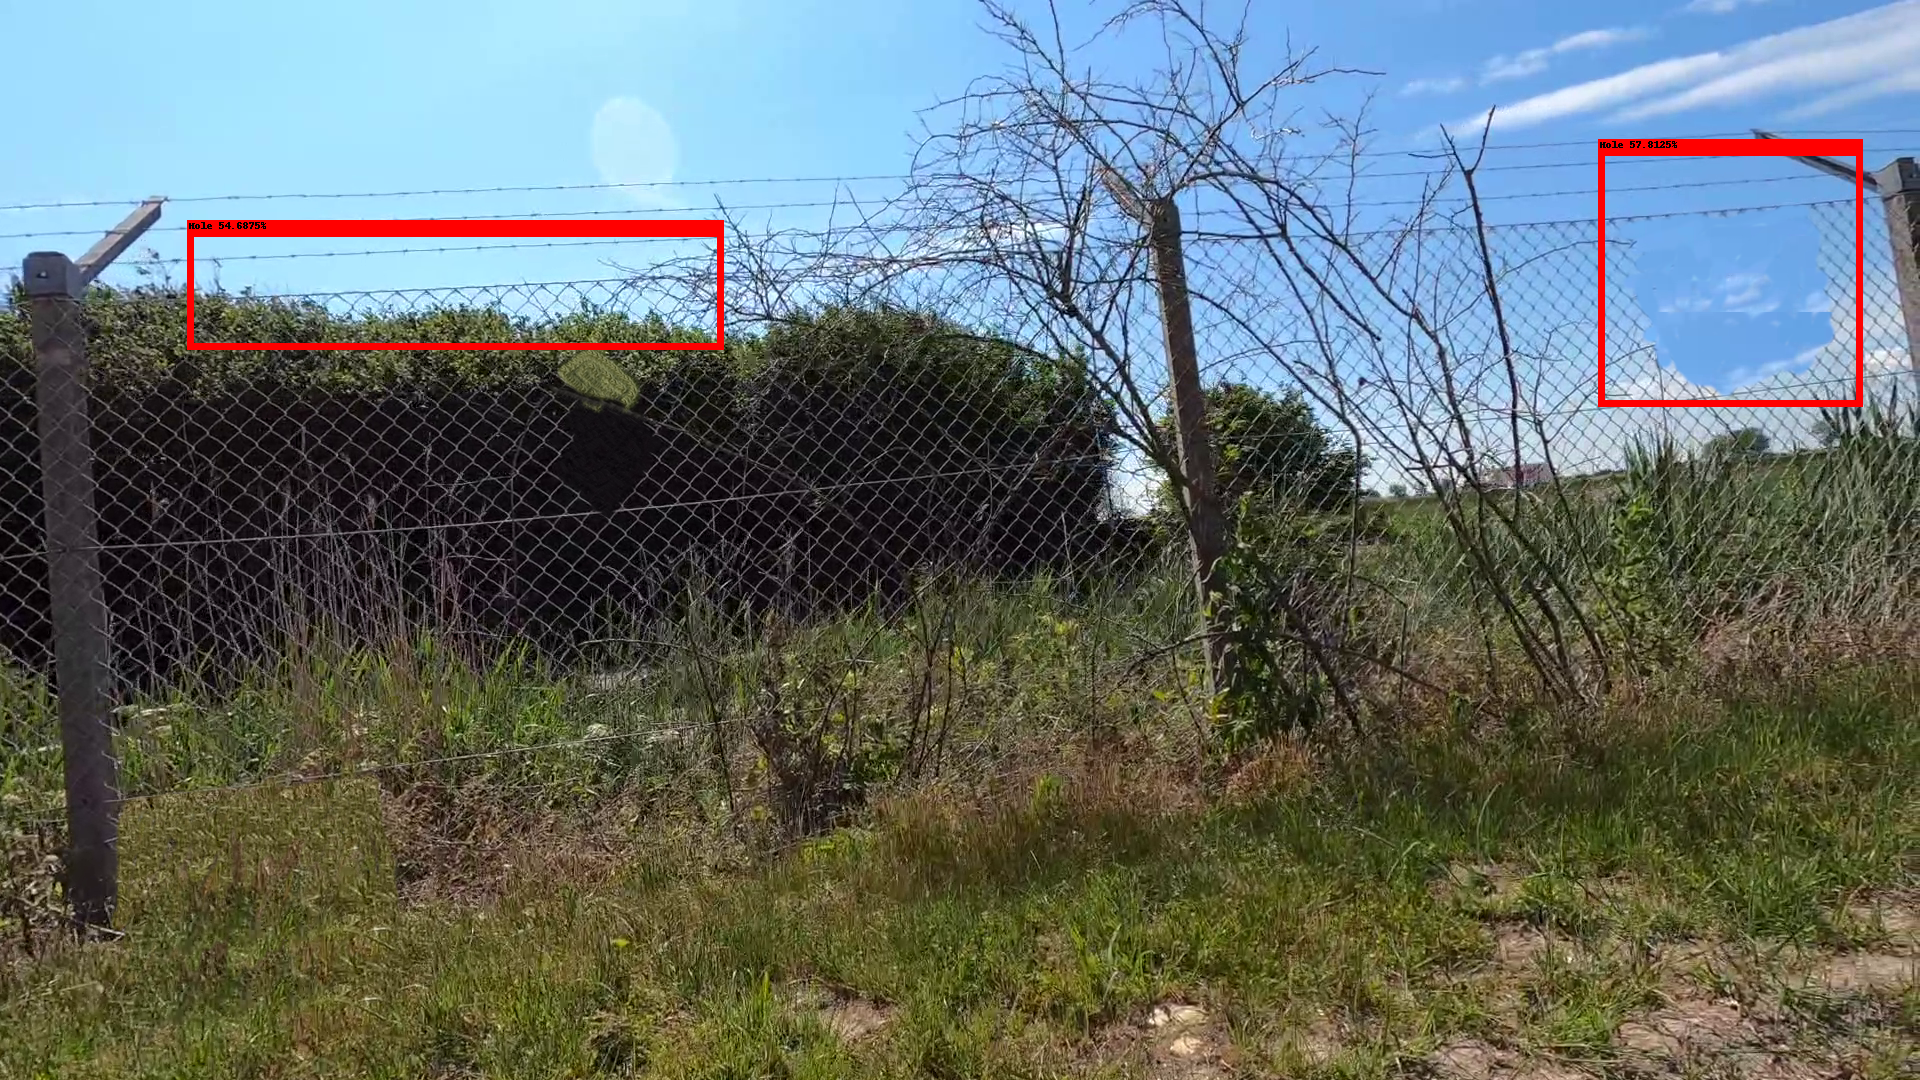

In [18]:
# Now we do evaluation on the tflite model.
import os
import numpy as np
from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

model_path = '/home/mikkel/Documents/experts_in_teams_proj/vision/tf_object_detection/output_models/ssdlite_mobiledet_fence_hole.tflite'

# Creates tflite interpreter
interpreter = Interpreter(model_path)
# This exact code can be used to run inference on the edgetpu by simply creating 
# the instantialize the interpreter with libedgetpu delegates:
#interpreter = Interpreter(model_path, experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def run_inference(interpreter, image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    boxes = interpreter.get_tensor(output_details[0]['index'])[0]
    classes = interpreter.get_tensor(output_details[1]['index'])[0]
    scores = interpreter.get_tensor(output_details[2]['index'])[0]
    # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
    return boxes, classes, scores

test_image_paths = ['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/Imgages+json/img/0002_synth_wholes.png'] #['/home/mikkel/Documents/experts_in_teams_proj/vision/data/tf_hole_fence/Imgages+json/img/0004.png']#[os.path.join('/home/mikkel/Documents/experts_in_teams_proj/vision/data/hca_images/', '000{}.png'.format(i)) for i in range(1, 6)] 
for image_path in test_image_paths:
    print('Evaluating:', image_path)
    image = Image.open(image_path)
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)
    resized_image = image.resize((width, height))
    np_image = np.asarray(resized_image)
    input_tensor = np.expand_dims(np_image, axis=0)
    # Run inference
    boxes, classes, scores = run_inference(interpreter, input_tensor)
    # Draw results on image
    colors = {0:(255, 0, 0)}
    labels = {0:'Hole'}
    for i in range(len(boxes)):
        if scores[i] > .5:
            ymin = int(max(1, (boxes[i][0] * image_height)))
            xmin = int(max(1, (boxes[i][1] * image_width)))
            ymax = int(min(image_height, (boxes[i][2] * image_height)))
            xmax = int(min(image_width, (boxes[i][3] * image_width)))
            draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
            draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
            text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
            draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
    display(image)